In [1]:
import numpy as np
import cv2
from skimage.external import tifffile as tiff
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_li
from skimage.transform import rescale


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


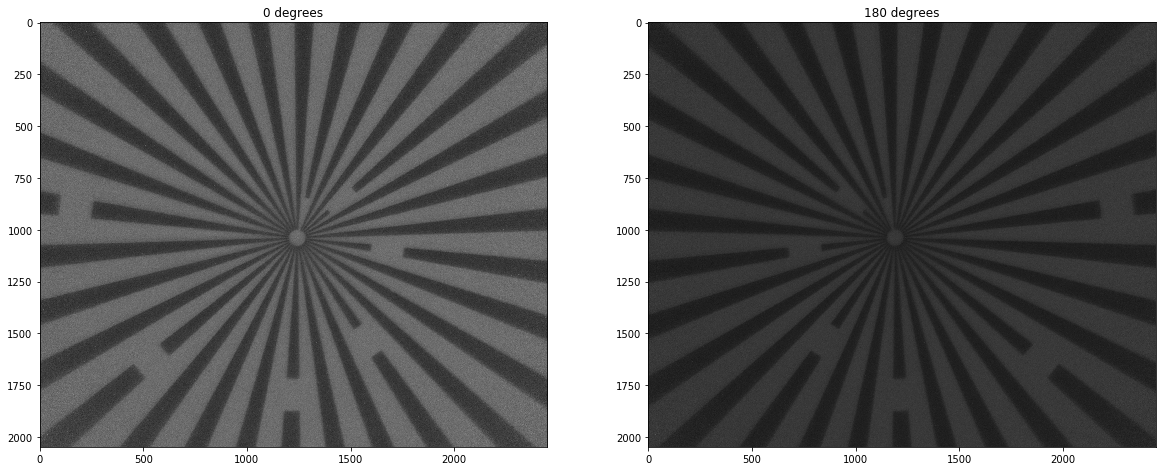

In [2]:
samples = ['./samples/rot_0.tif', 
           './samples/rot_180.tif',
           './samples/faked_rot_0_titled_5.3deg.tif',
           './samples/faked_rot_180.tif']

img0 = tiff.imread(samples[0])
img180 = tiff.imread(samples[1])

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img0, cmap='gray')
plt.title("0 degrees")
plt.subplot(122)
plt.imshow(img180, cmap='gray')
plt.title("180 degrees")
plt.show()


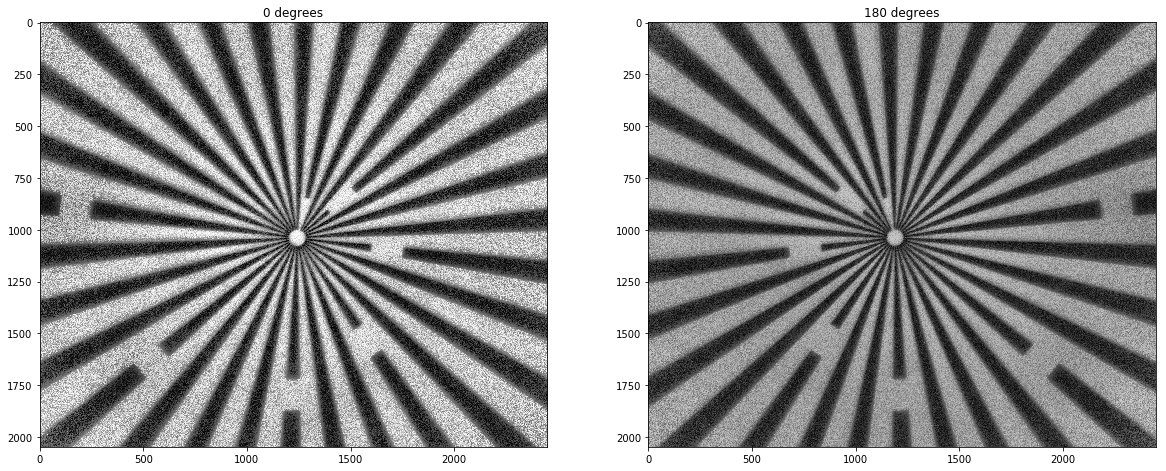

In [3]:
img0.shape
img0.dtype

img0

img0_adapteq = exposure.equalize_adapthist(img0, clip_limit=0.03)
img180_adapteq = exposure.equalize_adapthist(img180, clip_limit=0.03)

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img0_adapteq, cmap='gray')
plt.title("0 degrees")
plt.subplot(122)
plt.imshow(img180_adapteq, cmap='gray')
plt.title("180 degrees")
plt.show()

### Rescale image to speed up processing. Rescale to only 40% of the size. 

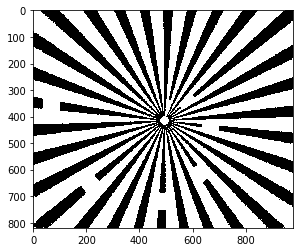

In [4]:
img0_rescaled = rescale(img0, 0.4, mode='reflect')
thresh = threshold_li(img0_rescaled)
binary = img0_rescaled > thresh

plt.imshow(binary, cmap='gray')
plt.show()

In [9]:
# Create few empty image for processing. 

img0_empty = np.zeros_like(binary, dtype=np.uint8)
img0_binary = np.zeros_like(binary, dtype=np.uint8)
img0_binary_inv = np.zeros_like(binary, dtype=np.uint8)

img0_binary[binary] = 255
img0_binary_inv[~binary] = 255

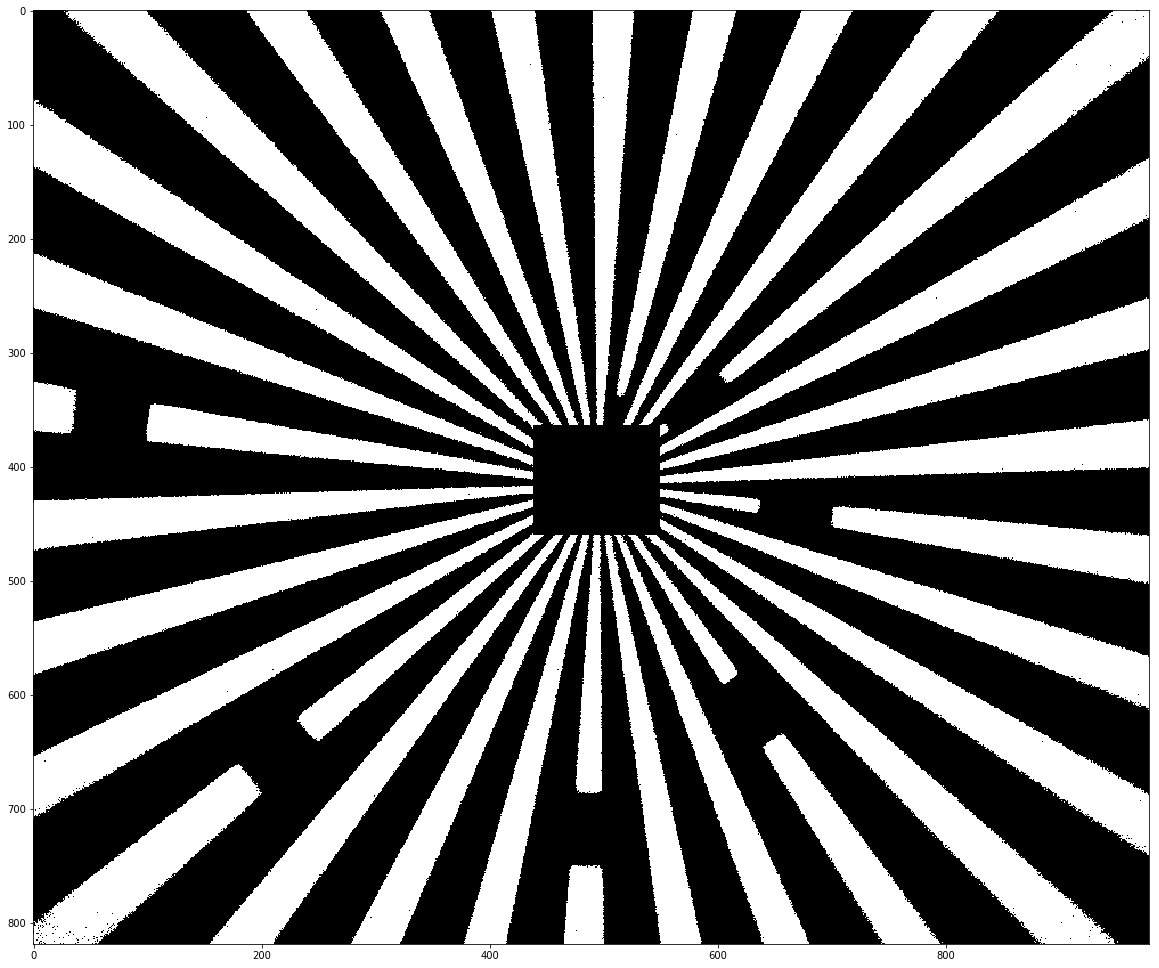

In [56]:
# Mask out center of image. 
h, w = img0_binary.shape
img0inv_masked = img0_binary_inv.copy()
mask = np.zeros_like(img0_binary, dtype=np.uint8)

vertices = np.array([[
                (w/2 - 50, h/2 - 45),
                (w/2 + 60, h/2 - 45), 
                (w/2 + 60, h/2 + 50), 
                (w/2 - 50, h/2 + 50)
            ]], 
                        dtype=np.int32)

cv2.fillPoly(mask, vertices, 255)
masked = cv2.bitwise_and(img0inv_masked, mask)
img0inv_masked[masked > 0] = 0

plt.figure(figsize=(20, 20))
plt.imshow(img0inv_masked, cmap='gray')
plt.show()



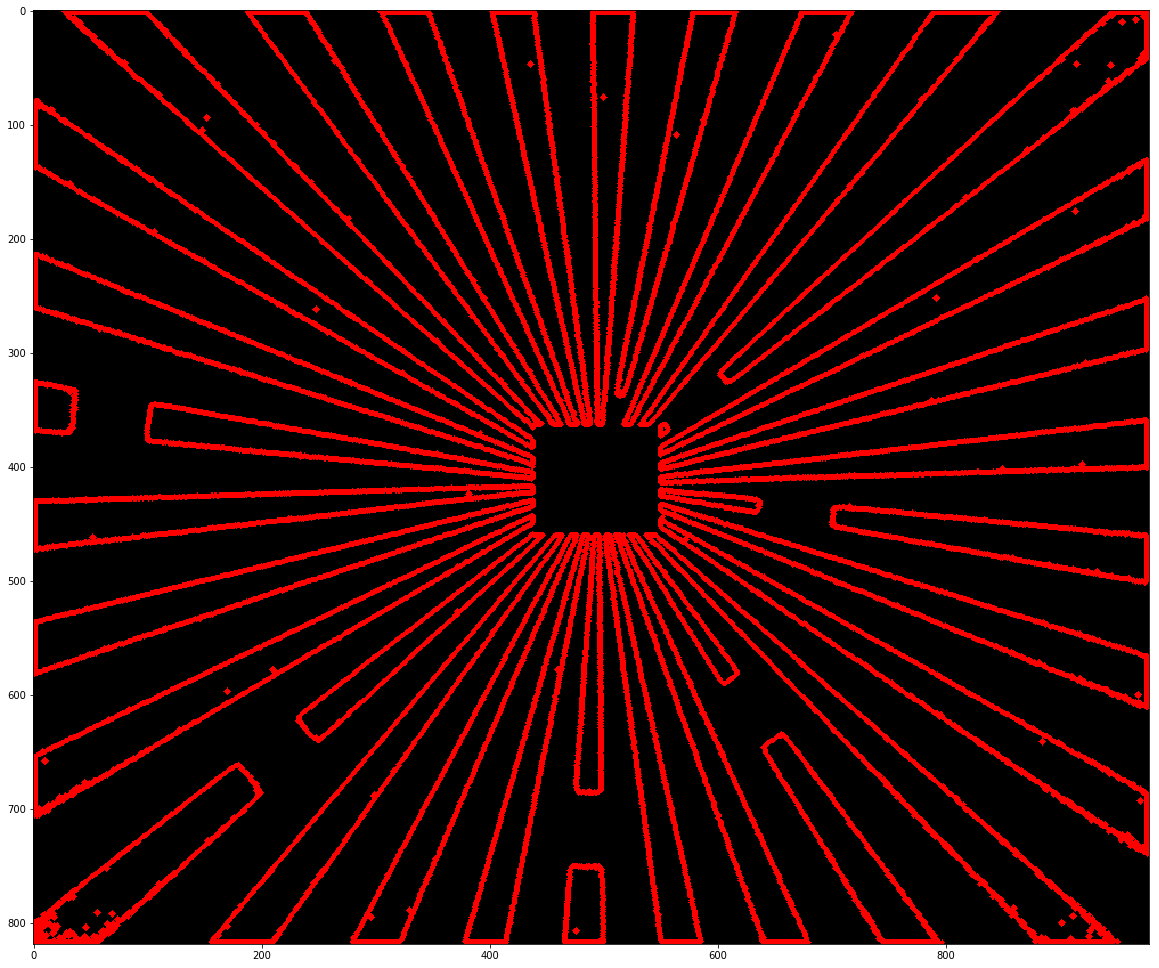

In [68]:
result = np.dstack((img0_empty, img0_empty, img0_empty))

im2, cnts, hierarchy = cv2.findContours(img0inv_masked.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE )
cv2.drawContours(result, cnts, -1, (255, 0, 0), 3)

plt.figure(figsize=(20, 20))
plt.imshow(result)

# fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 10))
# ax0.imshow(img0_binary, cmap='gray')
# ax1.imshow(img1_binary, cmap='gray')
# ax2.imshow(im2, cmap='gray')

plt.show()


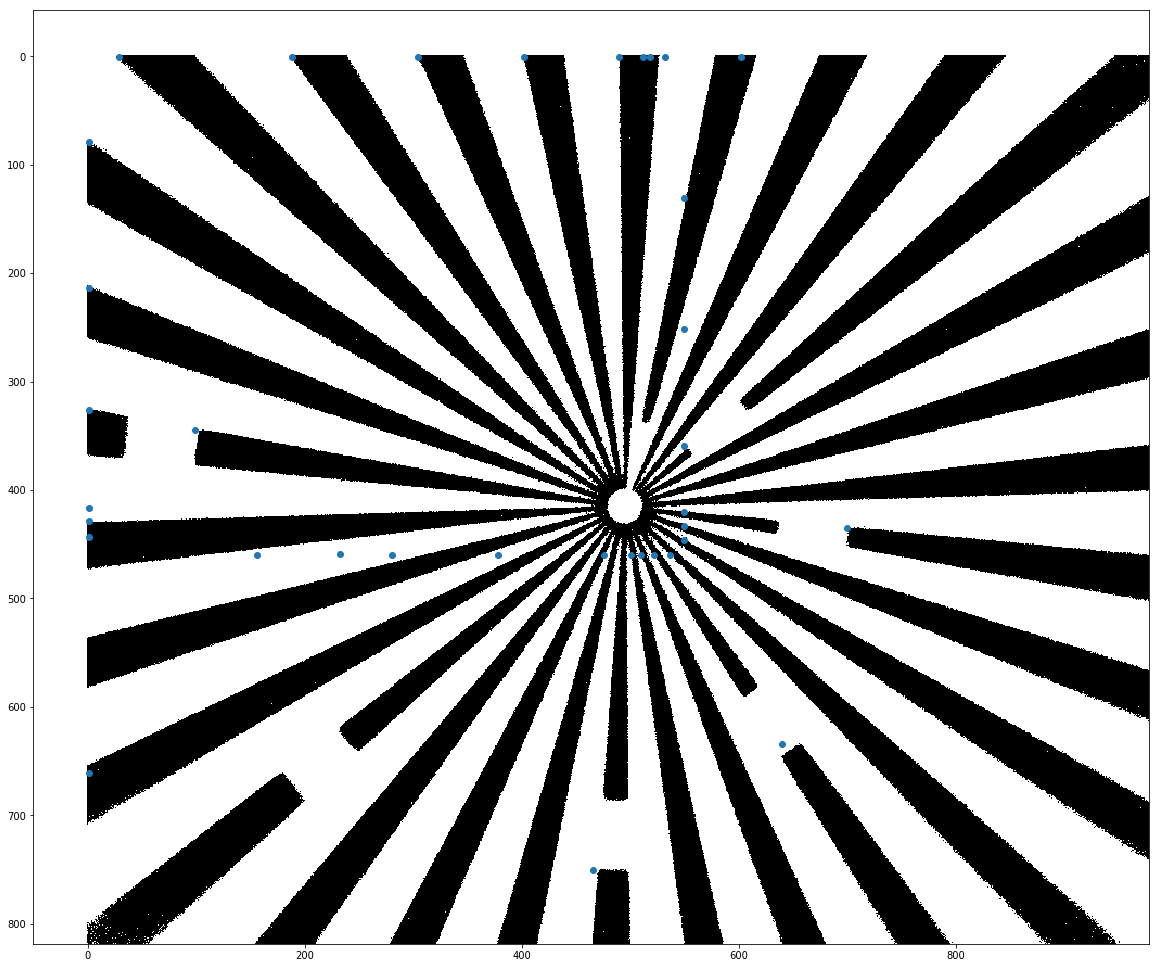

In [75]:
result = np.dstack((img0_binary, img0_binary, img0_binary))

X = []
Y = []

for cnt in cnts:
    area = cv2.contourArea(cnt)
    if int(area) <= 100 or int(area) > 80000:
        continue
#     rect = cv2.minAreaRect(cnt)
#     print (rect)
#     box = cv2.boxPoints(rect)
#     box = np.int0(box)
#     cv2.drawContours(result,[box],0,(0,0,255),2)

    x,y,w,h = cv2.boundingRect(cnt)
    X.append(x)
    Y.append(y)



plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.scatter(X, Y)
plt.show()


[[[425 658 425 654]]

 [[555 214 555 211]]

 [[456 472 459 469]]

 ..., 
 [[860 663 862 664]]

 [[497 556 497 558]]

 [[186 386 188 386]]]


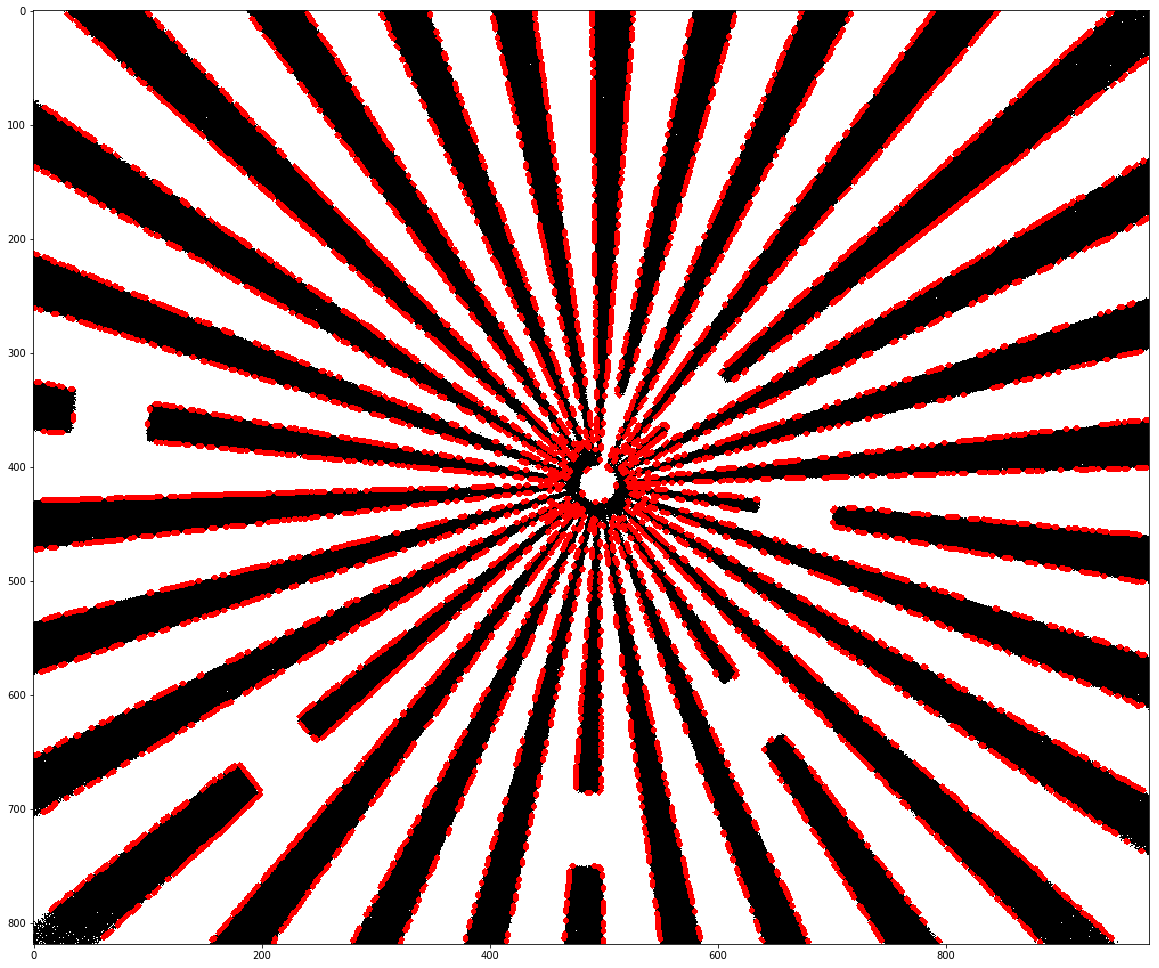

In [124]:

result = np.dstack((img0_binary, img0_binary, img0_binary))

blurred = cv2.GaussianBlur(img0_binary_inv, (7, 7), 0)
edges = cv2.Canny(blurred, 1, 255)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 1, 3, 2)

print (lines)
X = []
Y= []

for line in lines:
    for x1,y1, x2, y2 in line:
        cv2.line(result, (x1, y1), (x2, y2), [255, 0, 0], 3)
        X.append(x1)
        Y.append(y1)


#fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 20))
#ax0.imshow(edges, cmap='gray')
#ax1.imshow(result)
#ax1.scatter(X, Y)

plt.figure(figsize=(20, 20))
plt.imshow(result, cmap='gray')


